# Setup

In [1]:
import os
import requests
import pathlib
import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [2]:
# Constants
# Parameters for Deep Learning
EPOCHS=5
BATCH_SIZE=32
IMAGE_HEIGHT=224
IMAGE_WIDTH=224
AUGMENT_TARGET_COUNT=1000
NUMBER_OF_LAYERS_IN_CLASSIFICATION=2
NUMBER_OF_NODES_PER_LAYER_IN_CLASSIFICATION=256 #4096

# Test / Code constants
DATASET_URL='https://github.com/rencete/computer-vision-datasets/raw/master/apple-cabbage/Dataset.7z'
MODEL_FILENAME_N_PATH='model.h5'
MODEL_FIT_VERBOSITY=0
MODEL_EVALUATE_VERBOSITY=0
CLASSES=['apple', 'cabbage']
TRAIN_DATASET_BASEPATH='Dataset/train'
TEST_DATASET_BASEPATH='Dataset/test'

# Download and Extract Dataset

Download the dataset from my Github repo if it does not exist

In [3]:
# Retrieve the filename of the dataset from the URL
dataset_filename = DATASET_URL.split('/')[-1]

# Download the dataset from Github and save in current directory
if not os.path.isdir(dataset_filename):
  with open(dataset_filename,'wb') as f:
    f.write(requests.get(DATASET_URL).content)

In [4]:
# Check if the dataset has been uncompressed by checking if directory exists
if not os.path.isdir(TRAIN_DATASET_BASEPATH):
  !7z x Dataset.7z

# Dataset Research / Investigation

In [5]:
# Obtain paths for both apples and cabbages
train_dir = pathlib.Path(TRAIN_DATASET_BASEPATH)
apple_paths = list(train_dir.glob(CLASSES[0] + '/*.jpg'))
cabbage_paths = list(train_dir.glob(CLASSES[1] + '/*.jpg'))

Get counts of apples

In [6]:
# Get the count of apple input images from actual files
apples_count = len(apple_paths)
print(apples_count)

309


Get counts of cabbages

In [7]:
# Get the count of cabbage input images from actual files
cabbage_count = len(cabbage_paths)
print(cabbage_count)

96


Observation: training dataset in unbalanced with slightly more than three times more apples than cabbages.

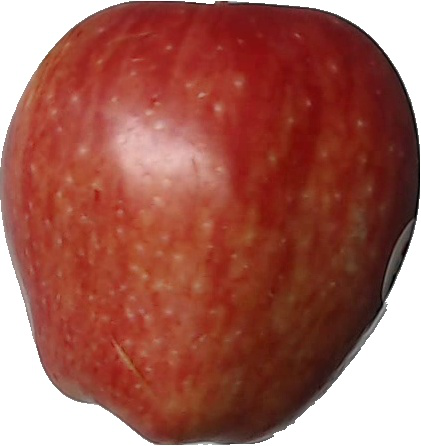

In [8]:
# View the first apple input image
sample_apple = PIL.Image.open(str(apple_paths[0]))
sample_apple

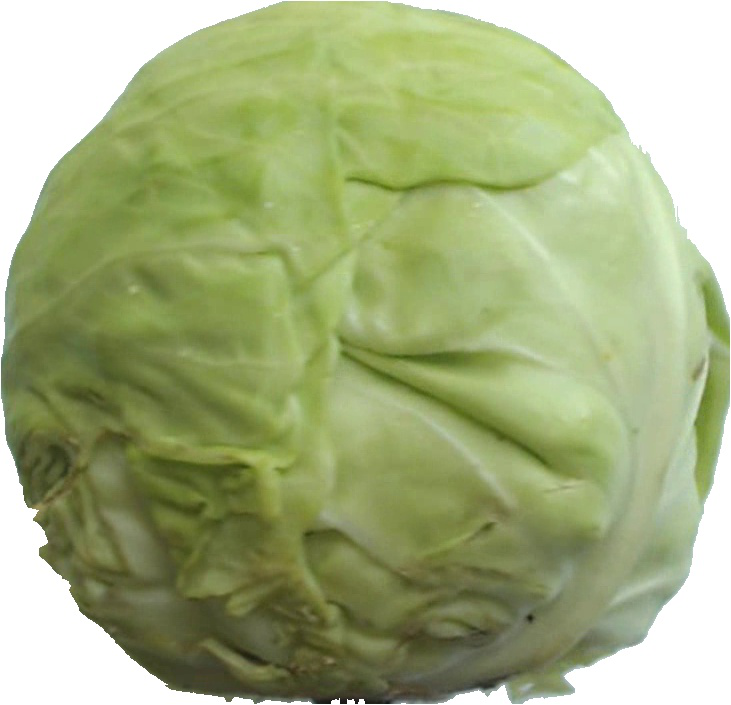

In [9]:
# View the first cabbage input image
sample_cabbage = PIL.Image.open(str(cabbage_paths[0]))
sample_cabbage

In [10]:
# Check sample apple image height and width
sample_apple.size

(421, 446)

In [11]:
# Check sample cabbage image height and width
sample_cabbage.size

(731, 705)

Observation: image sizes are different, need to resize to same image size for processing

# Image Classification Strategy Discussion

The images will be augmented for two reasons:
- to increase the number of training samples
- to make the count of images per class to be similar to prevent bias

Machine learning algorithms require that input images all have the same dimensions. Therefore images will be scaled/resize to fit the requirements of the algorithm. For this implementation, VGG16 architecture will be used for classification. Input images will be scaled to 224 x 224 to meet the input requirements of VGG16.

# Deep Learning Code

## Functions

In [12]:
'''
Creates an ImageDataGenerator instance used to augment input images.
Image augmentation enabled are rotation, shearing, flipping (horizontal and 
vertical), shifting (both x and y axis). Pixels outside the original image
is filled with white.
'''
def create_datagen():
  '''Returns a default ImageDataGenerator without any transformation enabled.'''
  datagen = ImageDataGenerator(fill_mode='constant', 
                               cval=255,
                               rotation_range=20, 
                               shear_range=20, 
                               horizontal_flip=True, 
                               vertical_flip=True, 
                               height_shift_range=0.1, 
                               width_shift_range=0.1, 
                               dtype=int)
  return datagen

In [13]:
'''
Augments the image dataset passed in to meet the target count.
The original dataset will be used as the first set. Additional augmented images
are created to meet the target as needed.
Will also truncate the dataset if target count is lees than original size.
'''
def augment_dataset(dataset, target_count):
  # Copy the original dataset as the first set
  augmented_dataset = dataset.copy()

  # Prepare image augmentation generator
  generator = create_datagen()
  # Fit the generator on the dataset
  generator.fit(dataset)
  # Prepare iterator for augmented images
  gen_flow = generator.flow(dataset, shuffle=False)

  # Augment images until the target is met
  while augmented_dataset.shape[0] < target_count:
    # Get next "batch" of augmented images
    augments = next(gen_flow)
    # Add augmented images to resulting set
    augmented_dataset = np.concatenate((augmented_dataset, augments))
  
  # Truncate resulting dataset if it is greater than target count
  if augmented_dataset.shape[0] > target_count:
    augmented_dataset = augmented_dataset[0:target_count]

  return augmented_dataset

In [14]:
'''
Load the images from the files and store as a dataset.
Also generates the labes for the dataset as: 0 - apple, 1 - cabbage.
'''
def load_ds_from_path(base_path: str, augment: bool = True):
  X = y = augmented_ds = labels = None

  # Iterate through the different classes
  for i, c in enumerate(CLASSES):
    path = pathlib.Path(f'{base_path}/{c}')

    # Load images from files
    ds = np.array([img_to_array(load_img(p, color_mode='rgb', target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))) for p in path.glob('*.jpg')])

    # Augment the data if needed
    if augment:
      augmented_ds = augment_dataset(ds, AUGMENT_TARGET_COUNT)
    else:
      augmented_ds = ds

    # Prepare labels
    if augment:
      labels = np.full((AUGMENT_TARGET_COUNT,), i)
    else:
      labels = np.full((augmented_ds.shape[0],), i)

    # Concatenate / merge datasets for output
    if X is None: 
      # initial case, no data to concatenate yet
      X = augmented_ds
      y = labels
    else:
      # concatenate with previously loaded/augmented data
      X = np.concatenate((X, augmented_ds))
      y = np.concatenate((y, labels))

  # Convert labels to one-hot-encoding
  y = to_categorical(y)

  return X, y

In [15]:
'''
Scale the pixel values in the range of 0 to 1 as a floating point value.
'''
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
 
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
  
	# return normalized images
	return train_norm, test_norm

In [16]:
'''
Shuffles the dataset and labels in the same order.
'''
def shuffle_x_and_y(x, y):
  # Generate array of indices
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)

  # Shuffle the indices
  idx = tf.random.shuffle(indices)

  # Reorder the dataset and labels based on the order of the shuffled indices
  x_data = tf.gather(x, idx)
  y_data = tf.gather(y, idx)
  return x_data, y_data

In [17]:
'''
Define and compile the image classification deep learning model.
Follows VGG16 architecture.
'''
def define_model():
  model = Sequential()

  # First set of convulution hidden layers
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(224,224,3)))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))    
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  
  # Second set of convulution hidden layers
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  
  # Third set of convulution hidden layers
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  
  # Fourth set of convulution hidden layers
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  
  # Fifth set of convulution hidden layers
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  # Flatten before connecting to fully interconnected layer for classification
  model.add(Flatten())

  # Customizeable (through hyperparameterized constants) of classification layer
  # Fully interconnected network
  for lc in range(NUMBER_OF_LAYERS_IN_CLASSIFICATION):
    model.add(Dense(units=NUMBER_OF_NODES_PER_LAYER_IN_CLASSIFICATION,activation="relu"))

  # Output layer
  model.add(Dense(units=2, activation="softmax"))
  
  # compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [18]:
'''
Trains the model based on passed dataset and labels.
'''
def train_model(model, X, y):
  # fit model
  model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=MODEL_FIT_VERBOSITY)
  # save model
  model.save(MODEL_FILENAME_N_PATH)

In [19]:
'''
Check model performance against test dataset
'''
def evaluate_model(testX, testY):
  # Load the saved model
  model = load_model(MODEL_FILENAME_N_PATH)

  # evaluate model on test dataset
  loss, acc = model.evaluate(testX, testY, verbose=MODEL_EVALUATE_VERBOSITY)
  
  # print performance metrics
  print("="*80)
  print("Model evaluation results as follows:")
  print('Loss: %.3f' % (loss * 100.0))
  print('Accuracy: %.3f' % (acc * 100.0))
  print("="*80)

In [20]:
'''
Run deep learning classification of apples vs cabbages
'''
def run_test_harness():
  # Load training dataset
  X_train, y_train = load_ds_from_path(TRAIN_DATASET_BASEPATH)

  # Load testing dataset
  # Note: not augmented
  X_test, y_test = load_ds_from_path(TEST_DATASET_BASEPATH, False)

  # Scale pixel values
  X_train, X_test = prep_pixels(X_train, X_test)

  # Shuffle order of images
  X_train, y_train = shuffle_x_and_y(X_train, y_train)
  X_test, y_test = shuffle_x_and_y(X_test, y_test)

  # Prepare model
  model = define_model()

  # Train model
  train_model(model, X_train, y_train)

  # Test model performance
  evaluate_model(X_test, y_test)

## Run

In [21]:
# Run the process until testing the model
run_test_harness()

Model evaluation results as follows:
Loss: 0.003
Accuracy: 100.000
